这个分析笔记由[Jake Vanderplas](http://www.vanderplas.com)编辑汇总. 源代码和license文件在[GitHub](https://github.com/jakevdp/sklearn_tutorial/)。 中文翻译由[派兰数据](http://datarx.cn)在[派兰大数据分析平台](http://palandata.com)上完成。

# 深度探索监督学习：随机森林

之前我们已经了解过了强大的判别分类器，**支持向量机**。在这里我们要看一看另一种强大的算法。这个算法是一个*非参数*方法，叫**随机森林**。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 使用seaborn的默认设置
import seaborn as sns; sns.set()

## 随机森林：决策树

随机森林是在决策树的基础上的一个*集成学习*算法。所以我们从讨论决策树开始我们的介绍，

决策树是一个非常直观的，给对象分类或者是贴标签的方法：您仅仅需要提出一系列的问题并回答它们，模型会根据问题的答案逐渐完善。

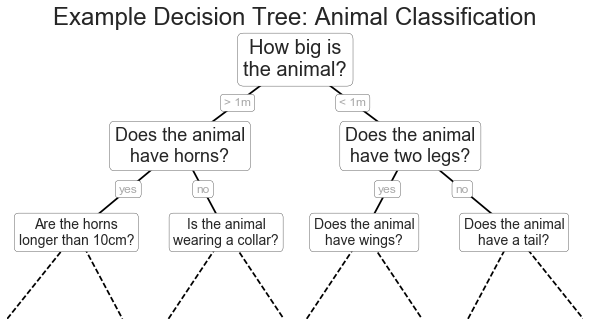

In [2]:
import fig_code
fig_code.plot_example_decision_tree()

对所有问题，仅需要回答"是"或者"否"，这让分类变得极其有效。但是，这里需要注意的是，我们需要*问应该问的问题*。在训练一个决策树分类器时，算法会根据问题的特征去找出哪一个问题包含着最多的信息。

### 创建一个决策树

这儿是一个在sklearn中决策树的例子。我们会以定义一组二维的有标签的数据开始：

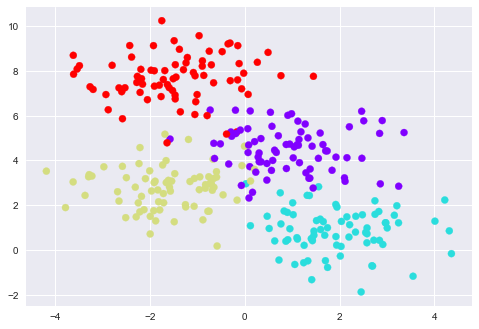

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

我们在sklearn的库中有一些可以提供帮助的函数：

In [4]:
from fig_code import visualize_tree, plot_tree_interactive

现在使用 IPython 的``interact`` (在 IPython2.0+ 中可以使用，且需要一个实时的核)。我们可以看到决策树的分隔:

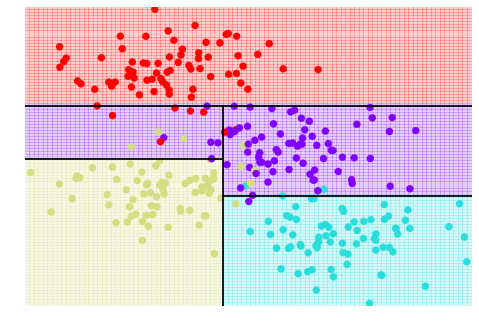

In [5]:
plot_tree_interactive(X, y);

注意到随着深度的增加，**除了**那些本来只包含一类的点之外，每一个数据集都被成功的划分。
这是个非常快的**无参数**分类过程，在实际运用中非常实用。

**问题：您看到这里隐含的缺陷了吗？**

### 决策树和过拟合

决策树的一个特点就是，它训练出来的模型非常容易产生**过拟合**。也就是说，模型的弹性非常大，以至于它们对数据的噪声的学习可以高过数据本身！比如，接下来我们可以看一看两种决策树模型，针对同一个数据集的两个子集的建模情况：

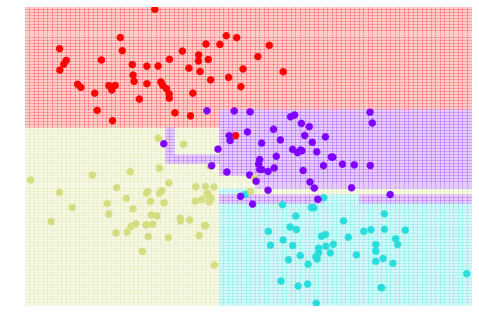

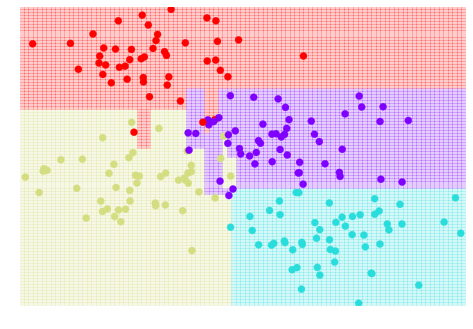

In [6]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

plt.figure()
visualize_tree(clf, X[:200], y[:200], boundaries=False)
plt.figure()
visualize_tree(clf, X[-200:], y[-200:], boundaries=False)

两种分类模型的细节完全不一样！这就是**过拟合**的一个直观展示：当你采用你的模型去预测一个新的点的时候，这个模型更容易被数据中的噪声而不是数据本身所影响。

## 集成学习Estimators：随机森林

一个可能的解决过拟合问题的方式是采用**集成方法**：创建一个总的estimator，它对很多的独立的，容易产生过拟合的estimator取了平均。让人有些惊讶的是，这个总的estimator的效果非常好，它比任何一个组成它的独立的estimator都要稳定和精确！

**随机森林**就是众多集成方法中的一种，这里，集成的意思是总的estimator会由很多决策树组成。

对于如何随机组合这些决策树，现在有很多方法和原理。但是，举个例子，我们来看一组estimator对于数据的不同子集建模的结果。我们可以通过接下来的内容获得更好的理解：

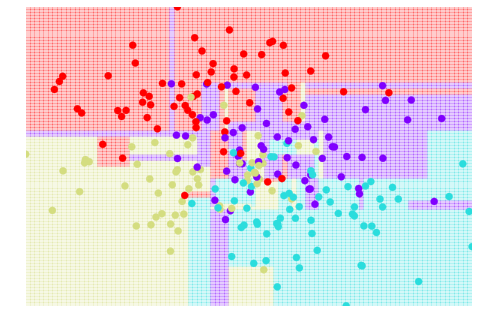

In [7]:
def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)
    
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
    
from IPython.html.widgets import interact
interact(fit_randomized_tree, random_state=[0, 100]);

我们可以看到，不管细节怎么随着函数的改变而改变，大的特征总是保持不变的！随机森林的分类器会做类似的事情，只是它会把所有的模型组合起来去得到最后的结果：

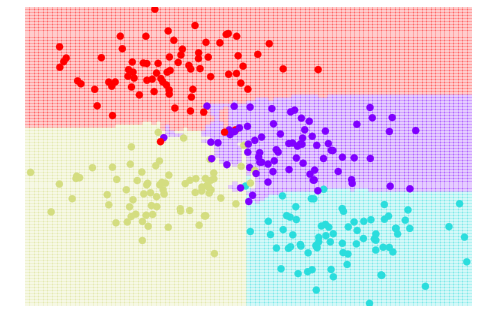

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_tree(clf, X, y, boundaries=False);

通过对100个随机的模型取平均，我们得到了一个可以更好拟合我们的数据的模型！

*(注意: 上面我们通过下采样的方式对我们的模型做了随机。随机森林运用了更加成熟的方法，对于这点您可以参考 [scikit-learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest)*)

## 例子：回归问题

我们在之前对随机森林的讨论都是基于分类问题的。
随机森林也可以被用在回归问题中(也就是，预测的是连续而不是离散的值)。对应的estimator是``sklearn.ensemble.RandomForestRegressor``.

我们快速的看一下它是如何使用的：

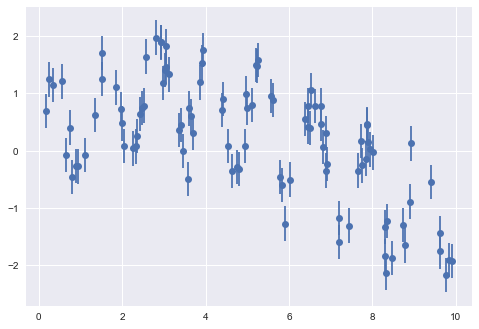

In [9]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

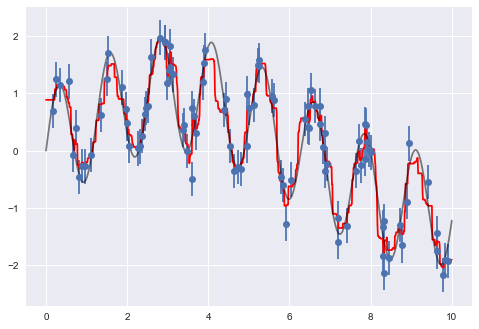

In [10]:
xfit = np.linspace(0, 10, 1000)
yfit = RandomForestRegressor(100).fit(x[:, None], y).predict(xfit[:, None])
ytrue = model(xfit, 0)

plt.errorbar(x, y, 0.3, fmt='o')
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

从中你可以看到，这个非参数的随机森林的模型足够去拟合多周期的数据，甚至都不需要我们为它指定一个多周期的模型！

## 例子：运用随机森林算法做数字分类

我们之前已经接触了**手写数字**的数据集。我们现在来对支持向量机分类器和随机森林分类器在数据集上的效率做一些评估。

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [12]:
X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


为了让我们更好的记起来手写数字数据集，我们先将其中一部分画出来：

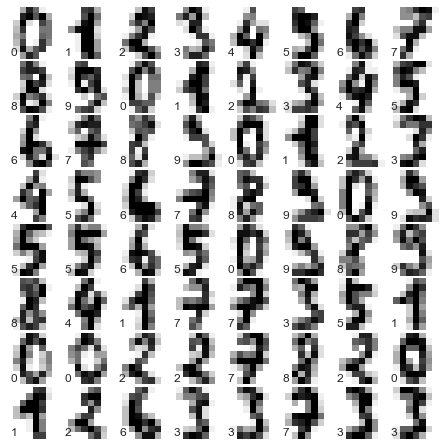

In [13]:
# 设置绘图
fig = plt.figure(figsize=(6, 6))  # 图片大小是以英寸(inches)计算的
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 绘制这些数字: 每个图像是 8x8 像素点阵的
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # 每一个图像做上对应的标记(label，就是target值)
    ax.text(0, 7, str(digits.target[i]))

我们可以使用决策树来快速的对数字进行分类：

In [14]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(max_depth=11)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

/Users/admin/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


我们可以检查一下这个分类器的准确率：

In [15]:
metrics.accuracy_score(ypred, ytest)

0.83111111111111113

为了更好的看出分类器的性能，我们画出混淆矩阵：

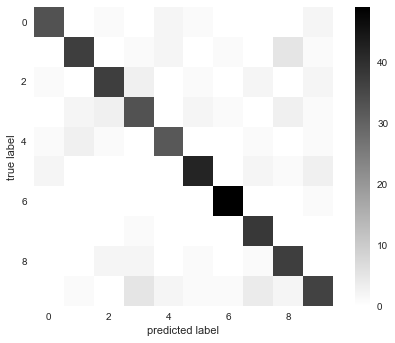

In [16]:
plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

### 练习
1. 用``sklearn.ensemble.RandomForestClassifier``在做一次分类任务。并回答``max_depth``，``max_features``和``n_estimators``是如何影响结果的？
2. 用``sklearn.svm.SVC``来做分类，调整``kernel``,``C``和``gamma``。哪一个分类器效果最好？
3. 针对每个模型尝试着用不同的参数去跑，查看结果的F1分数(``sklearn.metrics.f1_score``)。您能达到的最高的F1分数是什么？